In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from feature_functions import *
from scipy.io import loadmat
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV, LeaveOneOut
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut

In [2]:
# load data
mat_x = loadmat('Py_Input.mat')
mat_y = loadmat('Py_Output.mat')
data_x = mat_x['py_inputs'].T
quasiMVC = pd.read_csv('QuasiMVCData.csv')

In [3]:
# Define a class that stores our data and applies the signal processing techniques for more features (stored in feature_functions)

class EMG:
    
    def __init__(self, data_x):
        self.data_x = data_x
        self.new_features = {}
        
    def feat_signal_range(self):
        dat = []
        for subject in range(self.data_x.shape[0]):
            for stride in range(self.data_x.shape[1]):
                if self.data_x[subject][stride].size != 0:
                    dat.append(signal_range(self.data_x[subject][stride][1]))
        self.new_features['Signal Range'] = dat
        
    def feat_signal_mean(self):
        dat = []
        for subject in range(self.data_x.shape[0]):
            for stride in range(self.data_x.shape[1]):
                if self.data_x[subject][stride].size != 0:
                    dat.append(signal_mean(self.data_x[subject][stride][1]))
        self.new_features['Signal Mean'] = dat
    
    def feat_signal_kurtosis(self):
        dat = []
        for subject in range(self.data_x.shape[0]):
            for stride in range(self.data_x.shape[1]):
                if self.data_x[subject][stride].size != 0:
                    dat.append(signal_kurtosis(self.data_x[subject][stride][1]))
        self.new_features['Signal Kurtosis'] = dat

    def feat_signal_mean_abs(self):
        dat = []
        for subject in range(self.data_x.shape[0]):
            for stride in range(self.data_x.shape[1]):
                if self.data_x[subject][stride].size != 0:
                    dat.append(signal_mean_abs(self.data_x[subject][stride][1]))
        self.new_features['Signal Mean Absolute'] = dat
        
    def feat_signal_entropy(self):
        dat = []
        for subject in range(self.data_x.shape[0]):
            for stride in range(self.data_x.shape[1]):
                if self.data_x[subject][stride].size != 0:
                    dat.append(signal_entropy(self.data_x[subject][stride][1]))
        self.new_features['Signal Entropy'] = dat
        
    def feat_frequency_domain_features(self):
        
        dom_freq = []
        ratio = []
        spec_entropy = []
        for subject in range(self.data_x.shape[0]):
            for stride in range(self.data_x.shape[1]):
                if self.data_x[subject][stride].size != 0:
                    max_freq, max_freq_val, dom_freq_ratio, spec_ent = a_frequency_domain_features(self.data_x[subject][stride][1], 250, 400)
                    dom_freq.append(max_freq_val)
                    ratio.append(dom_freq_ratio[0])
                    spec_entropy.append(spec_ent)
        self.new_features['Dom Freq Val'] = dom_freq
        self.new_features['Dom Freq Ratio'] = ratio
        self.new_features['Spectral Entropy'] = spec_entropy
    
    def feat_autocovariance_IQR(self):
        dat = []
        for subject in range(self.data_x.shape[0]):
            for stride in range(self.data_x.shape[1]):
                if self.data_x[subject][stride].size != 0:
                    dat.append(a_autocovariance_IQR(self.data_x[subject][stride][1]))
        self.new_features['Autocov IQR'] = dat
        
    def feat_mean_cross_rate(self):
        dat = []
        for subject in range(self.data_x.shape[0]):
            for stride in range(self.data_x.shape[1]):
                if self.data_x[subject][stride].size != 0:
                    dat.append(a_mean_cross_rate(self.data_x[subject][stride][1]))
        self.new_features['Mean Cross Rate'] = dat

    def feat_rms_value(self):
        dat = []
        for subject in range(self.data_x.shape[0]):
            for stride in range(self.data_x.shape[1]):
                if self.data_x[subject][stride].size != 0:
                    dat.append(a_rms_value(self.data_x[subject][stride][1]))
        self.new_features['RMS'] = dat
        
    def calc_all(self):
        method_list = [method for method in dir(self) if method.startswith('feat') is True]
        for method in method_list:
            getattr(self, method)()  

In [4]:
# calculate new features
emg = EMG(data_x)
emg.calc_all()

In [5]:
# add new features to original data
for key, value in emg.new_features.items():
    quasiMVC[key] = value

In [34]:
# drop last row
quasiMVC = quasiMVC[0:1208]
quasiMVC

,Subject_all,MeanMVC_all,StrideTime_all,WalkingAmp_all,NumberofBursts_all,Autocov IQR,Dom Freq Val,Dom Freq Ratio,Spectral Entropy,Mean Cross Rate,RMS,Signal Entropy,Signal Kurtosis,Signal Mean,Signal Mean Absolute,Signal Range
0,1,0.000304,1.108515,0.000023,4,0.164652,0.003221,0.836233,0.522461,0.036972,0.000016,-9.984884,6.070187,0.000022,0.000022,0.000106
1,1,0.000304,1.119909,0.000034,3,0.118090,0.001882,0.601578,0.727376,0.027923,0.000042,-9.504546,8.553450,0.000033,0.000033,0.000241
2,1,0.000304,1.077508,0.000033,2,0.169131,0.003020,0.840233,0.512540,0.041667,0.000023,-9.563890,1.319121,0.000031,0.000031,0.000107
3,1,0.000304,1.055249,0.000023,4,0.077433,0.002691,0.693440,0.581150,0.064815,0.000020,-9.994156,12.165258,0.000022,0.000022,0.000143
4,1,0.000304,1.080900,0.000028,3,0.168559,0.003271,0.849606,0.509530,0.028933,0.000017,-9.805292,2.781357,0.000027,0.000027,0.000104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,32,0.000346,0.972248,0.000027,6,0.142660,0.002059,0.643218,0.694864,0.024145,0.000017,-10.286706,4.658078,0.000016,0.000016,0.000097
1204,32,0.000346,1.234164,0.000027,7,0.252696,0.002910,0.727456,0.598815,0.023734,0.000018,-10.050300,1.033393,0.000020,0.000020,0.000083
1205,32,0.000346,1.096998,0.000027,5,0.249902,0.002602,0.646817,0.652413,0.014235,0.000017,-10.090558,2.040678,0.000020,0.000020,0.000080
1206,32,0.000346,1.149520,0.000028,6,0.206772,0.002647,0.635954,0.659258,0.016978,0.000020,-9.956210,4.556238,0.000020,0.000020,0.000115


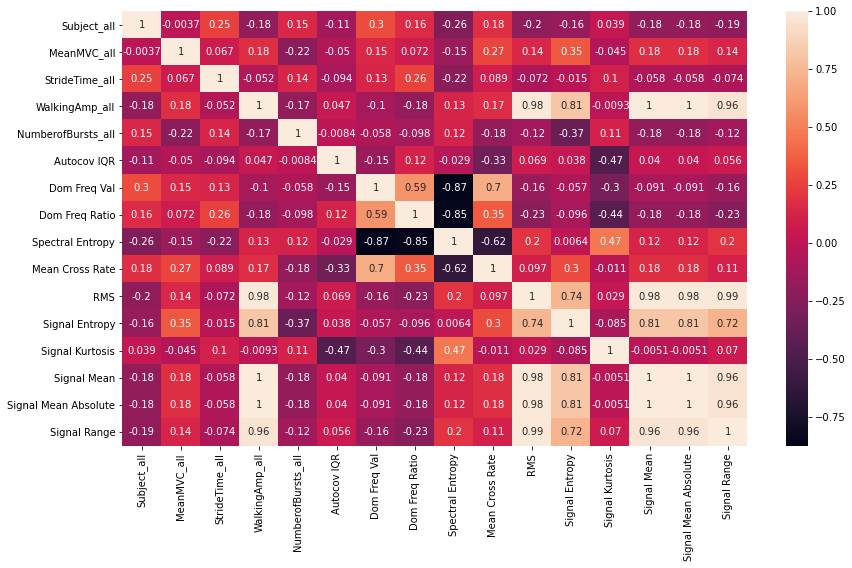

In [7]:
# show correlation plot
plt.figure(figsize=(14,8))
sn.heatmap(quasiMVC.corr(), annot=True)
plt.show()

In [8]:
# select features

feats = ['StrideTime_all', 'WalkingAmp_all',
       'NumberofBursts_all', 'Autocov IQR', 'Dom Freq Val', 'Dom Freq Ratio',
       'Spectral Entropy', 'Mean Cross Rate', 'RMS', 'Signal Entropy',
       'Signal Kurtosis', 'Signal Mean', 'Signal Mean Absolute',
       'Signal Range']

In [9]:
# store features matrix and output matrix

X = quasiMVC[feats].values
y = quasiMVC['MeanMVC_all'].values.ravel()

In [10]:
# split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# No CV

In [11]:
# run initial LR model
lr = linear_model.LinearRegression().fit(x_train, y_train)
lr.score(x_test, y_test)

0.1576725315780313

In [12]:
# run random forest model
rfr = RandomForestRegressor(random_state=3).fit(x_train, y_train)
rfr.score(x_test, y_test)

0.6239423860992919

# Leave One Out CV

In [14]:
# run LeaveOneOut with Linear Regression

cv = LeaveOneOut()

# enumerate splits
y_true, y_pred = list(), list()

for train_ix, test_ix in cv.split(X):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    # evaluate model
    yhat = model.predict(X_test)
    # store
    y_true.append(y_test[0])
    y_pred.append(yhat[0])
# calculate accuracy
acc = r2_score(y_true, y_pred)
print('R2: %.5f' % acc)

R2: 0.17682


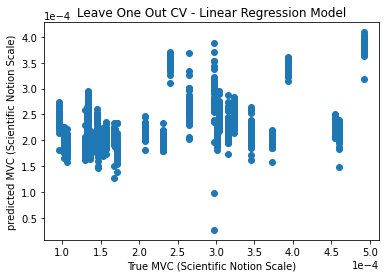

In [19]:
plt.scatter(y_true, y_pred)
plt.xlabel('True MVC (Scientific Notion Scale)')
plt.ylabel('predicted MVC (Scientific Notion Scale)')
plt.title("Leave One Out CV - Linear Regression Model")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [41]:
# run LeaveOneOut with Random Forest Regression
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in cv.split(X):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    model = RandomForestRegressor(random_state=1)
    model.fit(X_train, y_train)
    # evaluate model
    yhat = model.predict(X_test)
    # store
    y_true.append(y_test[0])
    y_pred.append(yhat[0])
# calculate accuracy
acc = r2_score(y_true, y_pred)
print('R2: %.5f' % acc)

R2: 0.64166


In [69]:
# show top features
feat_importance = pd.DataFrame(feats, np.round(model.feature_importances_, decimals=2)).reset_index().sort_values('index', ascending=False).rename(columns={'index':'importance', 0:'feature'})
feat_importance

,importance,feature
1,0.22,WalkingAmp_all
6,0.10,Spectral Entropy
0,0.09,StrideTime_all
8,0.09,RMS
4,0.08,Dom Freq Val
7,0.08,Mean Cross Rate
9,0.07,Signal Entropy
3,0.05,Autocov IQR
11,0.05,Signal Mean
12,0.05,Signal Mean Absolute


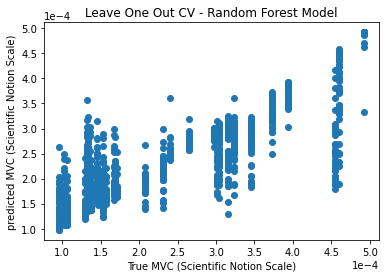

In [29]:
plt.scatter(y_true, y_pred)
plt.xlabel('True MVC (Scientific Notion Scale)')
plt.ylabel('predicted MVC (Scientific Notion Scale)')
plt.title("Leave One Out CV - Random Forest Model")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Group Shuffle Split

In [22]:
# try Leave One Group Out CV, despite poorer performance
groups = quasiMVC['Subject_all'].values.ravel()

In [30]:
logo = LeaveOneGroupOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in logo.split(X, groups=groups):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    # evaluate model
    yhat = model.predict(X_test)
    # store
    y_true.append(y_test[0])
    y_pred.append(yhat[0])
# calculate accuracy
acc = r2_score(y_true, y_pred)
print('R2: %.3f' % acc)

R2: -6.149


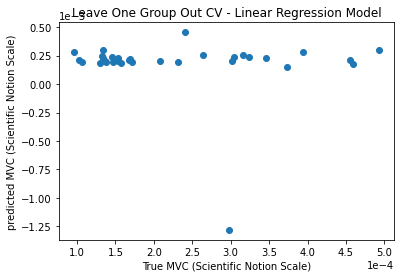

In [31]:
plt.scatter(y_true, y_pred)
plt.xlabel('True MVC (Scientific Notion Scale)')
plt.ylabel('predicted MVC (Scientific Notion Scale)')
plt.title("Leave One Group Out CV - Linear Regression Model")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [32]:
# run LeaveOneGROUPOut with Random Forest Regression
logo = LeaveOneGroupOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in logo.split(X, groups=groups):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    model = RandomForestRegressor(random_state=1)
    model.fit(X_train, y_train)
    # evaluate model
    yhat = model.predict(X_test)
    # store
    y_true.append(y_test[0])
    y_pred.append(yhat[0])
# calculate accuracy
acc = r2_score(y_true, y_pred)
print('R2: %.5f' % acc)

R2: -0.30266


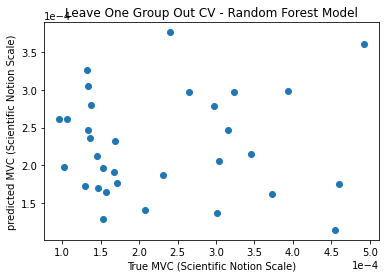

In [33]:
plt.scatter(y_true, y_pred)
plt.xlabel('True MVC (Scientific Notion Scale)')
plt.ylabel('predicted MVC (Scientific Notion Scale)')
plt.title("Leave One Group Out CV - Random Forest Model")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))